# Mandelbrot Set
The Mandelbrot set is the set of complex numbers $c$ for which the absolute value of the sequence $z_n$ remains bounded for all $n > 0$, where $z_n$ is:
$$
\begin{align}
z_0 &= 0, \\
z_{n+1} &= z_n^2 + c.
\end{align}
$$
For any complex number $c$, one of two things will happen:
- The sequence blows up to infinity ($|z_n| \gt 2$)
- The sequence if bounded ($|z_n| \le 2$)

Then, $c$ belongs to the Mandelbrot set $M$ if the second case ($|z_n| \le 2$) holds:
$$
M = \{c \in \mathbb{C} \mid \lvert z_n \rvert \le 2 \}.
$$

In [31]:
#imports
import time
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import multiprocessing as mp
import queue
import shelve
from statistics import NormalDist
import seaborn as sns
import pandas as pd
import scipy
from scipy.stats import t, f



# plot settings
mpl.rcParams["figure.dpi"] = 180
mpl.rcParams["legend.fontsize"] = 12
mpl.rcParams["font.size"] = 12

TEX_PLOTS = False

if TEX_PLOTS:
    plt.rc("text", usetex=True)
    plt.rc("text.latex", preamble=r"""
     \usepackage{palatino}
     \usepackage{newpxmath}""")
else:
    plt.rc("text", usetex=False)
    
plt.rc("font", family="serif")

In [35]:
from cpp_stoch import (
    f_c as f_c_cpp,
    mandelbrot_grid,
    set_num_threads,
    get_num_threads
)

from helpers import Monte_carlo, I_iter_worker, S_iter_worker, \
  uniform_sampler, latin_square_sampler, orthogonal_sampler, N_iter_worker, optimal_orthogonal_sampler, \
  scrambled_halton_sampler, scrambled_sobol_sampler

In [33]:
# RNG initialization for parallel sampling
#  see https://albertcthomas.github.io/good-practices-random-number-generators/
#  and https://numpy.org/doc/stable/reference/random/bit_generators/mt19937.html#numpy.random.MT19937
from numpy.random import Generator, MT19937, SeedSequence

def initialize_parallel_rngs(n, seed):
    sg = SeedSequence(seed)
    bit_generator = MT19937(sg)
    rngs = []
    for _ in range(n):
        rngs.append(Generator(bit_generator))
        bit_generator = bit_generator.jumped()
        
    return rngs

In [34]:
from scipy import stats

def Confidence_intervals(Samples, p = 0.95):
    Lambda = NormalDist().inv_cdf((p + 1)/2)
    S = np.std(Samples, ddof = 1)
    a = (Lambda*S)/np.sqrt(len(Samples))
    return a

def sp_confidence_interval(samples, p=0.95):
    a = stats.t.interval(p, df=len(samples)-1, loc=np.mean(samples), scale=stats.sem(samples))
    return a[1] - a[0]

In [5]:
def S_iter(max_iter, n_runs, S_min_exp, S_max_exp, seed, sampling_method = uniform_sampler, steps = 4):
    manager = mp.Manager()

    Approx_areas_list = manager.list()  
    sample_size_range = np.logspace(S_min_exp, S_max_exp, num = ((S_max_exp - S_min_exp) + 1)*steps, dtype = int)

    work_queue = mp.Queue()
    for i in range(n_runs):
        Approx_areas_list.append(manager.list())
        for sample_size in sample_size_range:
            work_queue.put((sample_size, i))


    rngs = initialize_parallel_rngs(mp.cpu_count(), seed)
    processes = []
    for i in range(mp.cpu_count()):
        p = mp.Process(target=S_iter_worker, args=(
            work_queue, Approx_areas_list, max_iter, rngs[i], sampling_method
        ))
        p.daemon = True
        p.start()
        processes.append(p)


    for p in processes:
        p.join()

    return [list(v) for v in Approx_areas_list], sample_size_range        

In [47]:
def I_iter(sample_size, n_runs, I_min_exp, I_max_exp, seed, sampling_method = uniform_sampler, steps = 4):
    manager = mp.Manager()

    Approx_areas_list = manager.list()  
    iteration_range = np.logspace(I_min_exp, I_max_exp, num = ((I_max_exp - I_min_exp) + 1)*steps, dtype = int)

    work_queue = mp.Queue()
    for i in range(n_runs):
        Approx_areas_list.append(manager.list())
        for max_iter in iteration_range:
            work_queue.put((max_iter, i))

    rngs = initialize_parallel_rngs(mp.cpu_count(), seed)
    processes = []
    for i in range(mp.cpu_count()):
        p = mp.Process(target=I_iter_worker, args=(
            work_queue, Approx_areas_list, sample_size, rngs[i], sampling_method 
        ))
        p.daemon = True
        p.start()
        processes.append(p)

    for p in processes:
        p.join()

    return [list(v) for v in Approx_areas_list], iteration_range

In [69]:
def Plotter_S(Approx_areas_list, sample_size_range):
    Approx_areas_list_array = np.array(Approx_areas_list)
    Area_means = np.mean(Approx_areas_list_array, axis = 0)
    # a = np.array([Confidence_intervals(samples) for samples in Approx_areas_list_array.T])
    a_scipy = [sp_confidence_interval(samples) for samples in Approx_areas_list_array.T]

    Error = np.abs(Area_means - Area_means[-1])

    #conf_lower = Area_means - a
    #conf_upper = Area_means + a
    
    fig,ax = plt.subplots(figsize=(5.25, 4))
    
    plt.grid(alpha=0.2)
    
    ax.plot(sample_size_range, Area_means, marker=".", color = "tab:blue", zorder=3)
    # ax.fill_between(sample_size_range, conf_lower, conf_upper, color='tab:red', alpha=0.1)
    ax.fill_between(sample_size_range, Area_means - a_scipy, Area_means + a_scipy, color='tab:blue', alpha=0.1)

    ax2=ax.twinx()
    ax2.plot(sample_size_range, Error, color = "black", linestyle='dashed', zorder=1)
    ax2.set_ylim(-0.05, 0.65)
    
    ax.set_xscale('log')
    ax.set_ylim(0.5, 2.6)
    ax.yaxis.label.set_color('tab:blue')

    if TEX_PLOTS:
        ax.set_ylabel("Mean approximated area $A_{s}$")
        ax.set_xlabel("Number of samples ($s$)")
        ax2.set_ylabel("Difference mean area $\\left\\lvert A_{s_\\text{max}} - A_{s_j}\\right\\rvert$")
        plt.savefig('figures/convergence_varying_s.pdf', bbox_inches='tight')
    else:
        ax.set_ylabel("Mean approximated area A_ns")
        ax.set_xlabel("Number of samples (s)")
        ax2.set_ylabel("Difference mean area (|A_smax - A_i|)")
    
    plt.show()

In [194]:
def Plotter_I(Approx_areas_list, iteration_range):
    Approx_areas_list_array = np.array(Approx_areas_list)
    Area_means = np.mean(Approx_areas_list_array, axis = 0)
    # Area_std = np.std(Approx_areas_list_array, axis = 0, ddof = 1)
    a_scipy = [sp_confidence_interval(samples) for samples in Approx_areas_list_array.T]
    Error = np.abs(Area_means - Area_means[-1])


    #std_lower = Area_means - Area_std
    #std_upper = Area_means + Area_std
    
    fig,ax = plt.subplots(figsize=(5.25, 4))
    
    plt.grid(alpha=0.2)
    
    ax.plot(iteration_range, Area_means, marker=".", color = "tab:blue", zorder=3)
    ax.fill_between(iteration_range, Area_means - a_scipy, Area_means + a_scipy, color='tab:blue', alpha=0.1)

    ax2=ax.twinx()
    ax2.plot(iteration_range, Error, color = "black", linestyle='dashed', zorder=1)
            
    ax.set_xscale('log')
    ax.set_ylim(0.5, 2.6)
    ax.yaxis.label.set_color('tab:blue')
    ax2.set_ylim(-0.05, 0.65)
    
    if TEX_PLOTS:
        ax.set_ylabel("Mean approximated area $A_{n}$")
        ax.set_xlabel("Number of iterations ($n$)")
        ax2.set_ylabel("Difference mean area $\\left\\lvert A_{n_\\text{max}} - A_{n_j}\\right\\rvert$")
        plt.savefig('figures/convergence_varying_i.pdf', bbox_inches='tight')
    else:
        ax.set_ylabel("Mean approximated area A_ns")
        ax.set_xlabel("Number of iteration (i)")
        ax2.set_ylabel("Difference mean area (A_n_maxs - A_n_js)")

    plt.show()

In [38]:
def N_iter(S_fix, I_fix, sampling_method, seed):
    manager = mp.Manager()

    Approx_areas_list = manager.dict()  
    runs_size_range = np.linspace(10, 1000, 20, dtype = int)
    work_queue = mp.Queue()
    
    for runs_size in runs_size_range:
        Approx_areas_list[runs_size] = manager.list()
        
        for i in range(runs_size):
            work_queue.put((runs_size, i))

        rngs = initialize_parallel_rngs(mp.cpu_count(), seed)
        processes = []
        for i in range(mp.cpu_count()):
            p = mp.Process(target=N_iter_worker, args=(
                work_queue, Approx_areas_list, S_fix, I_fix, rngs[i], sampling_method
            ))
            p.daemon = True
            p.start()
            processes.append(p)


        for p in processes:
            p.join()

    return {k: list(v) for k, v in Approx_areas_list.copy().items()}, runs_size_range    



def Plotter_N(Dic_PRS, Dic_LHS, Dic_OS):
    Sampling_methods = [Dic_PRS, Dic_LHS, Dic_OS]
    fig,ax = plt.subplots(figsize=(5.25, 4))
    fig2,ax2 = plt.subplots(figsize=(5.25, 4))
    run_size_range = list(Dic_PRS.keys())
    
    for Sampling_method in Sampling_methods:
        Approx_areas_list = list(Sampling_method.values())
        
        Area_means = []
        a_scipy = []
        
        for row in Approx_areas_list:
            mean = sum(row)/len(row)
            a = sp_confidence_interval(row)
            Area_means.append(mean)
            a_scipy.append(a)  
        
        Area_means = np.array(Area_means)
        a_scipy = np.array(a_scipy)
        
        Error = np.abs(Area_means - Area_means[-1])
        ax2.plot(run_size_range, Error, linestyle='dashed')
        
        ax.fill_between(run_size_range, Area_means - a_scipy, Area_means + a_scipy, alpha=0.2)
        ax.plot(run_size_range, Area_means, marker=".")
    
    ax.legend(["PRS", "LHS", "OS"]), ax2.legend(["PRS", "LHS", "OS"])
    ax.grid(alpha=0.2), ax2.grid(alpha=0.2)    
    #ax.set_ylim(1.495, 1.517)
    #ax2.set_ylim(0, 0.005)
    
    ax2.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
    
    if TEX_PLOTS:
        ax.set_ylabel("Mean approximated area $A_{r}$")
        ax.set_xlabel("Number of runs ($r$)")
        ax2.set_xlabel("Number of runs ($r$)")
        ax2.set_ylabel("Difference mean area $\\left\\lvert A_{r_\\text{max}} - A_{r_j}\\right\\rvert$")
        fig.savefig('figures/comparison_means_N.pdf', bbox_inches='tight')
        fig2.savefig('figures/comparison_differences_N.pdf', bbox_inches='tight')
    else:
        ax.set_ylabel("Mean approximated area A_is")
        ax.set_xlabel("Number of runs (r)")
        ax2.set_xlabel("Number of runs (r)")
        ax2.set_ylabel("Difference mean area (A_js - A_is)")

    plt.show()

In [196]:
def Statistics_print(Approx_areas_list, sample_size_range):
    Approx_areas_list_array = np.array(Approx_areas_list)
    Area_means = np.mean(Approx_areas_list_array, axis = 0)
    Area_std = np.std(Approx_areas_list_array, axis = 0, ddof = 1)
    a = [sp_confidence_interval(samples) for samples in Approx_areas_list_array.T]
    a2 = np.array([Confidence_intervals(samples) for samples in Approx_areas_list_array.T])
    Error = np.abs(Area_means- Area_means[-1])
    print("Means: ", Area_means)
    print("Error: ", Error)
    print("Confidence radius scipy: ", a)
    print("Confidence radius old: ", a2)

    print("Std: ", Area_std)

### Uniform results ###

In [197]:
#%%time
# Generate and save objects
#shelf = shelve.open("Final_arrays_simulations/S_iter")
#Approx_areas_list_S_Uni, sample_size_range_S_Uni = S_iter(max_iter = int(1e4), n_runs = 50, S_min_exp = 1, S_max_exp = 7, seed=523235)
#shelf["Approx_areas_list_S_Uni"] = Approx_areas_list_S_Uni
#shelf["sample_size_range_S_Uni"] = sample_size_range_S_Uni
#shelf.close()

In [198]:
# Open objects to work with 
shelf = shelve.open("Final_arrays_simulations/S_iter")
Approx_areas_list_S_Uni = shelf["Approx_areas_list_S_Uni"]
sample_size_range_S_Uni = shelf["sample_size_range_S_Uni"]
shelf.close()

In [199]:
Statistics_print(Approx_areas_list_S_Uni, sample_size_range_S_Uni)

Means:  [1.62624    1.6296     1.62881546 1.55620483 1.50981818 1.57529302
 1.48340093 1.5330585  1.50487613 1.5067584  1.50764892 1.50666168
 1.51097919 1.50834575 1.50556098 1.50750212 1.50452606 1.50743765
 1.50820858 1.50665615 1.5069203  1.50717497 1.50641739 1.50776032
 1.50687365 1.5069233  1.50706791 1.50699966]
Error:  [1.19240339e-01 1.22600339e-01 1.21815797e-01 4.92051695e-02
 2.81852038e-03 6.82933618e-02 2.35987312e-02 2.60588344e-02
 2.12353456e-03 2.41261440e-04 6.49259423e-04 3.37979197e-04
 3.97952408e-03 1.34608901e-03 1.43868583e-03 5.02455159e-04
 2.47359989e-03 4.37984520e-04 1.20891456e-03 3.43513727e-04
 7.93588399e-05 1.75312599e-04 5.82266834e-04 7.60655513e-04
 1.26013512e-04 7.63583076e-05 6.82442029e-05 0.00000000e+00]
Confidence radius scipy:  [0.5181739928661568, 0.4716667863980768, 0.3388347952938022, 0.22905903010147854, 0.17822147605695138, 0.1554811511984866, 0.11942961551970255, 0.08525893746065805, 0.07138033255851228, 0.0506039439966286, 0.03738285

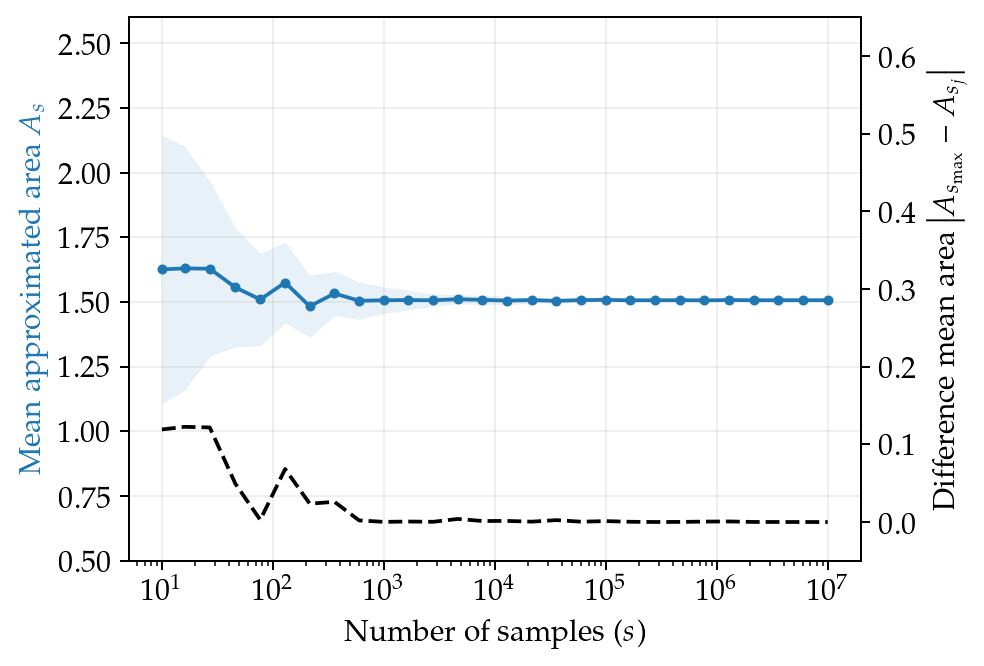

In [238]:
Plotter_S(Approx_areas_list_S_Uni, sample_size_range_S_Uni)

In [201]:
#%%time
# Generate and save objects
#shelf = shelve.open("Final_arrays_simulations/I_iter")
#Approx_areas_list_I_Uni, iteration_range_I_Uni = I_iter(sample_size = int(1e4), n_runs = 50, I_min_exp = 1, I_max_exp = 7, seed = 4345)
#shelf["Approx_areas_list_I_Uni"] = Approx_areas_list_I_Uni
#shelf["iteration_range_I_Uni"] = iteration_range_I_Uni
#shelf.close()

In [202]:
# Open objects to work with 
shelf = shelve.open("Final_arrays_simulations/I_iter")
Approx_areas_list_I_Uni = shelf["Approx_areas_list_I_Uni"]
iteration_range_I_Uni = shelf["iteration_range_I_Uni"]
shelf.close()

In [203]:
Approx_areas_list_array_I_Uni = np.array(Approx_areas_list_I_Uni)
Area_means_I_Uni = np.mean(Approx_areas_list_array_I_Uni, axis = 0)
Area_std_I_Uni = np.std(Approx_areas_list_array_I_Uni, axis = 0)
Error_I_Uni = np.abs(Area_means_I_Uni - Area_means_I_Uni[-1])

In [204]:
print("Means: ", Area_means_I_Uni)
print("Error: ", Error_I_Uni)
print("Std: ", Area_std_I_Uni)

Means:  [2.10092736 1.8206496  1.66665408 1.59819072 1.56006144 1.54390656
 1.5300768  1.51243008 1.52029248 1.5079008  1.51122048 1.5091776
 1.51447296 1.50452736 1.51204032 1.51023936 1.50647616 1.51263168
 1.51183872 1.51029312 1.50647616 1.50073728 1.513344   1.50815616
 1.50310272 1.50466176 1.50459456 1.50079104]
Error:  [6.0013632e-01 3.1985856e-01 1.6586304e-01 9.7399680e-02 5.9270400e-02
 4.3115520e-02 2.9285760e-02 1.1639040e-02 1.9501440e-02 7.1097600e-03
 1.0429440e-02 8.3865600e-03 1.3681920e-02 3.7363200e-03 1.1249280e-02
 9.4483200e-03 5.6851200e-03 1.1840640e-02 1.1047680e-02 9.5020800e-03
 5.6851200e-03 5.3760000e-05 1.2552960e-02 7.3651200e-03 2.3116800e-03
 3.8707200e-03 3.8035200e-03 0.0000000e+00]
Std:  [0.03208978 0.0284167  0.02186263 0.03378384 0.02984172 0.02879306
 0.02394895 0.02680927 0.02499934 0.03369294 0.02361021 0.02608953
 0.02471076 0.03334898 0.02968093 0.02513564 0.02745391 0.02803437
 0.03319151 0.02722992 0.02442617 0.03044229 0.02367119 0.0307450

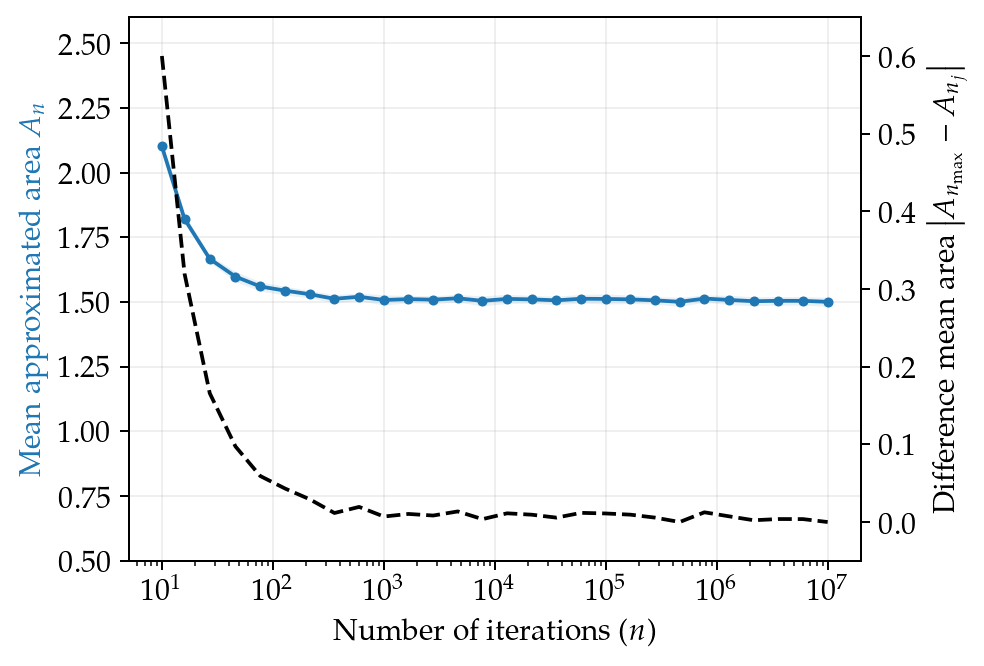

In [239]:
Plotter_I(Approx_areas_list_I_Uni, iteration_range_I_Uni)

### Comparison sampling techniques (n runs changing)

In [206]:
##%%time
#shelf = shelve.open("Final_arrays_simulations/R_iter")
#Dic_PRS, runs_size_range = N_iter(int(1e5), int(1e4), sampling_method = uniform_sampler, seed=983752)
#Dic_LHS, runs_size_range = N_iter(int(1e5), int(1e4), sampling_method = latin_square_sampler, seed=796)
#Dic_OS, runs_size_range = N_iter(int(1e5), int(1e4), sampling_method = orthogonal_sampler, seed=63723)

#shelf["Dic_PRS"] = Dic_PRS
#shelf["Dic_LHS"] = Dic_LHS
#shelf["Dic_OS"] = Dic_OS
#shelf["runs_size_range"] = runs_size_range
#shelf.close()

In [207]:
#%%time
#shelf = shelve.open("Final_arrays_simulations/R_iter")
#Dic_OOS, runs_size_range = N_iter(int(1e2), int(1e2), sampling_method = optimal_orthogonal_sampler, seed=238574)
#Dic_PRS, runs_size_range = N_iter(int(1e2), int(1e2), sampling_method = uniform_sampler, seed=773319)
#Dic_LHS, runs_size_range = N_iter(int(1e2), int(1e2), sampling_method = latin_square_sampler, seed=832632)
#shelf["Dic_PRS_10^2"] = Dic_PRS
#shelf["Dic_LHS_10^2"] = Dic_LHS
#shelf["Dic_OS_10^2"] = Dic_OS
#shelf["runs_size_range"] = runs_size_range
#shelf.close()

In [208]:
shelf = shelve.open("Final_arrays_simulations/R_iter")
Dic_PRS = shelf["Dic_PRS"]  
Dic_LHS = shelf["Dic_LHS"]  
Dic_OS = shelf["Dic_OS"]

Dic_PRS_bad = shelf["Dic_PRS_10^2"]  
Dic_LHS_bad = shelf["Dic_LHS_10^2"]  
Dic_OS_bad = shelf["Dic_OS_10^2"]

shelf.close()

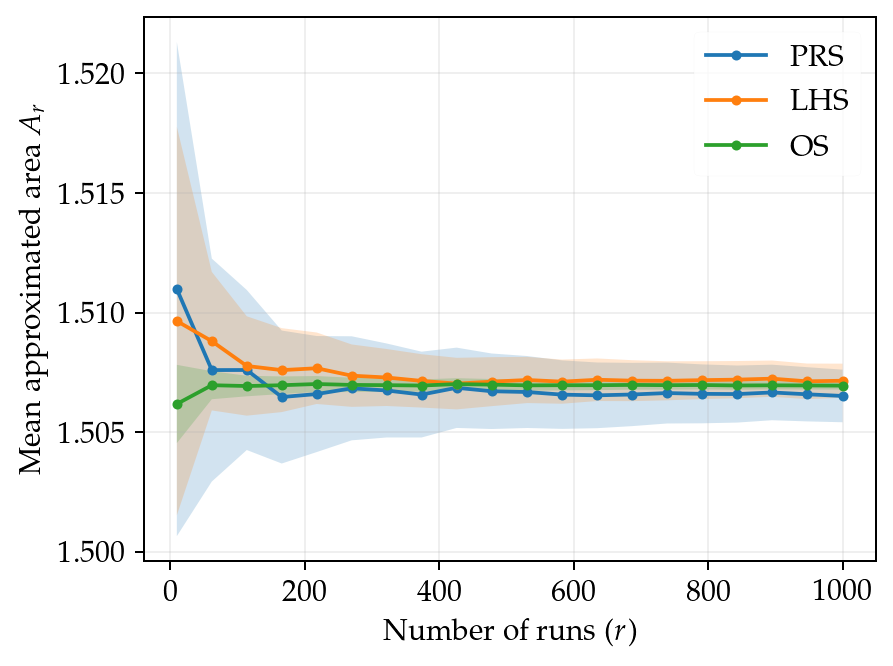

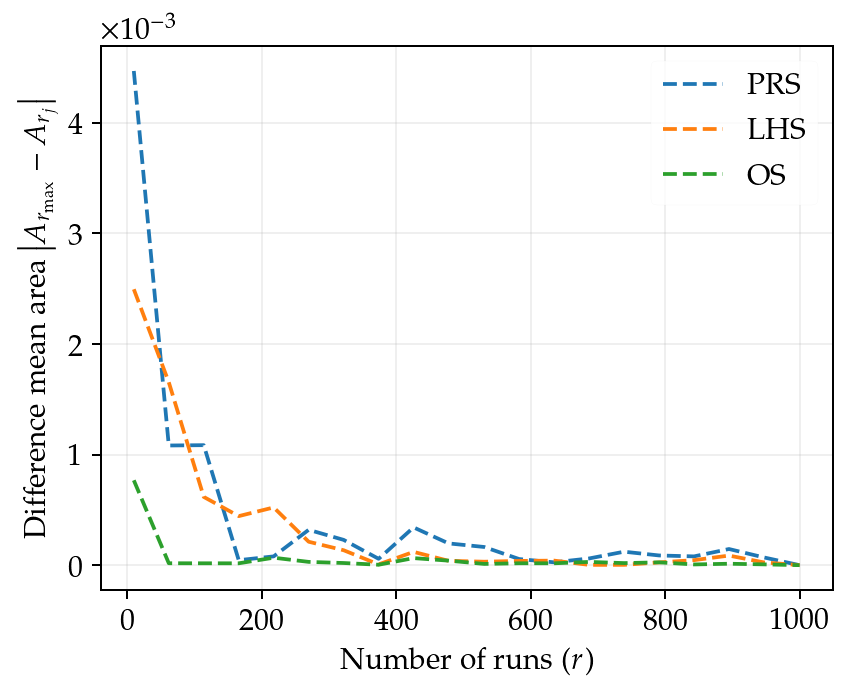

In [240]:
Plotter_N(Dic_PRS, Dic_LHS, Dic_OS)
#Plotter_N(Dic_PRS_bad, Dic_LHS_bad, Dic_OS_bad)

### Quasi-Monte Carlo method

In [41]:
def Plotter_N_Quasi(Quasi, OS, Quasi_sobol):
    Sampling_methods = [OS, Quasi, Quasi_sobol]
    fig,ax = plt.subplots(figsize=(5.25, 4))
    fig2,ax2 = plt.subplots(figsize=(5.25, 4))
    run_size_range = list(Quasi.keys())
    colors = ("tab:green", "tab:red", "tab:purple")
    
    
    for i, Sampling_method in enumerate(Sampling_methods):
        Approx_areas_list = list(Sampling_method.values())
        
        Area_means = []
        a_scipy = []
        
        for row in Approx_areas_list:
            mean = sum(row)/len(row)
            a = sp_confidence_interval(row)
            Area_means.append(mean)
            a_scipy.append(a)  
        
        Area_means = np.array(Area_means)
        a_scipy = np.array(a_scipy)
        
        Error = np.abs(Area_means - Area_means[-1])
        ax2.plot(run_size_range, Error, linestyle='dashed', color=colors[i])
        ax.fill_between(run_size_range, Area_means - a_scipy, Area_means + a_scipy, alpha=0.1, color=colors[i])
        ax.plot(run_size_range, Area_means, color=colors[i], marker=".")
    
    ax.legend(["OS", "RQMC (Halton)", "RQMC (Sobol)"]), ax2.legend(["OS", "RQMC (Halton)", "RQMC (Sobol)"])
    ax.grid(alpha=0.2), ax2.grid(alpha=0.2)    
    #ax.set_ylim(1.495, 1.517)
    #ax2.set_ylim(0, 0.005)
    
    ax2.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
    
    if TEX_PLOTS:
        ax.set_ylabel("Mean approximated area $A_{r}$")
        ax.set_xlabel("Number of runs ($r$)")
        ax2.set_xlabel("Number of runs ($r$)")
        ax2.set_ylabel("Difference mean area $\\left\\lvert A_{r_\\text{max}} - A_{r_j}\\right\\rvert$")
        fig.savefig('figures/comparison_os_qmc.pdf', bbox_inches='tight')
        fig2.savefig('figures/differences_os_qmc.pdf', bbox_inches='tight')
    else:
        ax.set_ylabel("Mean approximated area A_is")
        ax.set_xlabel("Number of runs (r)")
        ax2.set_ylabel("Difference mean area (A_js - A_is)")

    plt.show()

In [40]:
#%%time
#shelf = shelve.open("Final_arrays_simulations/Quasi_vs_OS")
#Dic_Quasi, runs_size_range = N_iter(int(2**17), int(1e4), sampling_method = scrambled_halton_sampler, seed=126512)
#shelf["Dic_Quasi"] = Dic_Quasi
#Dic_Quasi_sobol, runs_size_range = N_iter(int(2**17), int(1e4), sampling_method = scrambled_sobol_sampler, seed=14512)
#shelf["Dic_Quasi_sobol"] = Dic_Quasi_sobol
#Dic_OS, runs_size_range = N_iter(int(2**17), int(1e4), sampling_method = orthogonal_sampler, seed=7320)
#shelf["Dic_OS"] = Dic_OS
#shelf["runs_size_range"] = runs_size_range
#shelf.close()

In [43]:
shelf = shelve.open("Final_arrays_simulations/Quasi_vs_OS")
Approx_areas_list_Quasi = shelf["Dic_Quasi"]
Approx_areas_list_OS = shelf["Dic_OS"]
Approx_areas_list_Quasi_sobol = shelf["Dic_Quasi_sobol"] 
shelf.close()

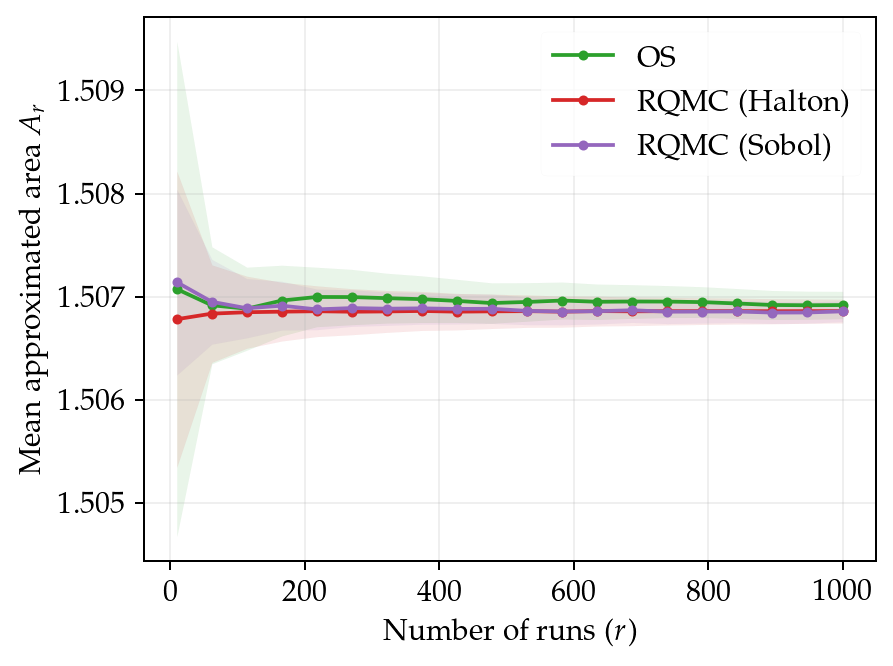

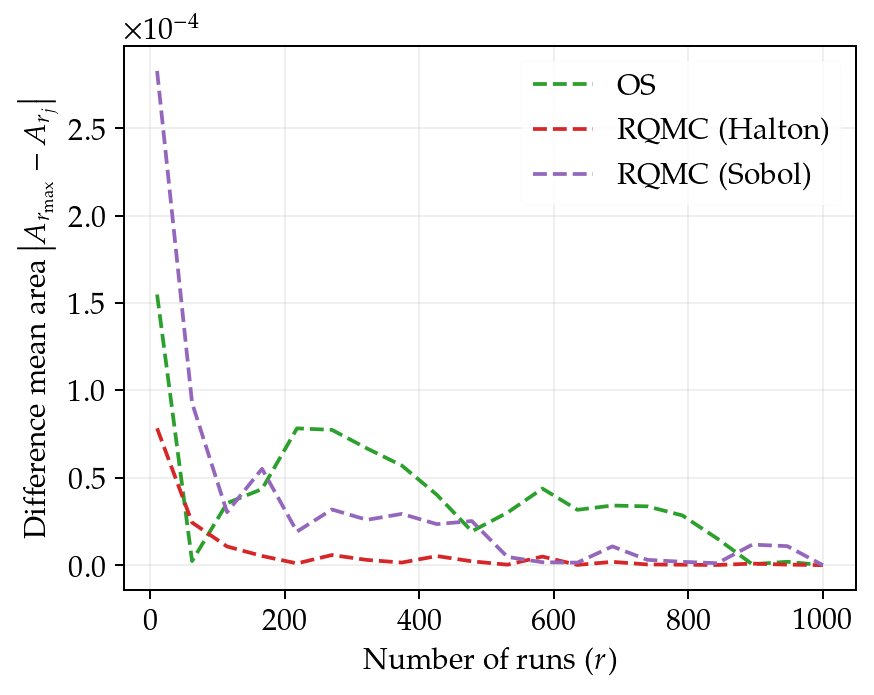

In [45]:
Plotter_N_Quasi(Approx_areas_list_Quasi, Approx_areas_list_OS, Approx_areas_list_Quasi_sobol)

### Statistical Tests and plots

In [214]:
#%%time
#Chosen samples
#Estimator after convergence (10^5 samples, 10^4 iteration)
#shelf = shelve.open("Final_arrays_simulations/Final_samples")
#Approx_areas_list_I_Uni, iteration_range_I_Uni = I_iter(sample_size = int(1e5), n_runs = 500, I_min_exp = 4, I_max_exp = 4, steps = 1, seed=22019)
#Approx_areas_list_I_LHS, iteration_range_I_LHS = I_iter(sample_size = int(1e5), n_runs = 500, I_min_exp = 4, I_max_exp = 4, sampling_method= latin_square_sampler, steps = 1, seed=7682932)
#Approx_areas_list_I_OS, iteration_range_I_OS = I_iter(sample_size = int(1e5), n_runs = 500, I_min_exp = 4, I_max_exp = 4, sampling_method= orthogonal_sampler, steps = 1, seed=672391)
#Approx_areas_list_I_QMS, iteration_range_I_QMS = I_iter(sample_size = int(1e5), n_runs = 500, I_min_exp = 4, I_max_exp = 4, sampling_method= scrambled_halton_sampler, steps = 1, seed=672391)
#shelf["Approx_area_S_10^5_I_10^4_LHS"] = Approx_areas_list_I_LHS
#shelf["Approx_area_S_10^5_I_10^4_Uni"] = Approx_areas_list_I_Uni
#shelf["Approx_area_S_10^5_I_10^4_OS"] = Approx_areas_list_I_OS
#shelf["Approx_area_S_10^5_I_10^4_QMS"] = Approx_areas_list_I_QMS
#shelf.close()

##### Average estimator

In [8]:
#Open objects to work with
shelf = shelve.open("Final_arrays_simulations/Final_samples")
Approx_areas_list_LHS_Av_est = shelf["Approx_area_S_10^5_I_10^4_LHS"] 
Approx_areas_list_Uni_Av_est = shelf["Approx_area_S_10^5_I_10^4_Uni"] 
Approx_areas_list_OS_Av_est = shelf["Approx_area_S_10^5_I_10^4_OS"] 
shelf.close()

#Put list in right format (meaning not a list of list)
Approx_areas_list_Uni_Av_est = sum(Approx_areas_list_Uni_Av_est, [])
Approx_areas_list_LHS_Av_est = sum(Approx_areas_list_LHS_Av_est, [])
Approx_areas_list_OS_Av_est = sum(Approx_areas_list_OS_Av_est, [])

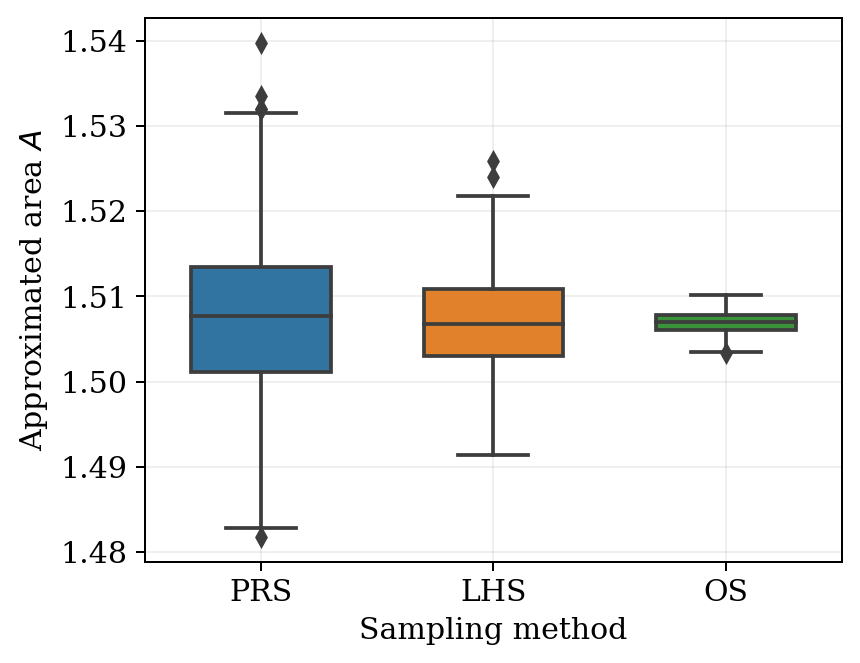

In [9]:
fig = plt.figure(figsize=(5, 4))

Values_Uniform = np.array(Approx_areas_list_Uni_Av_est)
Values_LHS = np.array(Approx_areas_list_LHS_Av_est)
Values_OS = np.array(Approx_areas_list_OS_Av_est)
Data_uniform = np.array([np.repeat("PRS", len(Values_Uniform)), Values_Uniform])
Data_LHS = np.array([np.repeat("LHS", len(Values_LHS)), Values_LHS])
Data_OS = np.array([np.repeat("OS", len(Values_OS)), Values_OS])
Data = np.concatenate([Data_uniform, Data_LHS, Data_OS], axis = 1)

df = pd.DataFrame(Data.T, columns = ["Sampling methods", "Approximated Area"])
df = df.astype({"Approximated Area" : float})
ax = sns.boxplot(x="Sampling methods", y="Approximated Area",  data=df, width = 0.6, zorder=3)
ax.set_axisbelow(True)
plt.grid(alpha = 0.2, zorder=0)
plt.ylabel("Approximated area $A$")
plt.xlabel("Sampling method")

if TEX_PLOTS:
    plt.savefig('figures/boxplot_sampling_differences.pdf',  bbox_inches='tight')
    
plt.show()

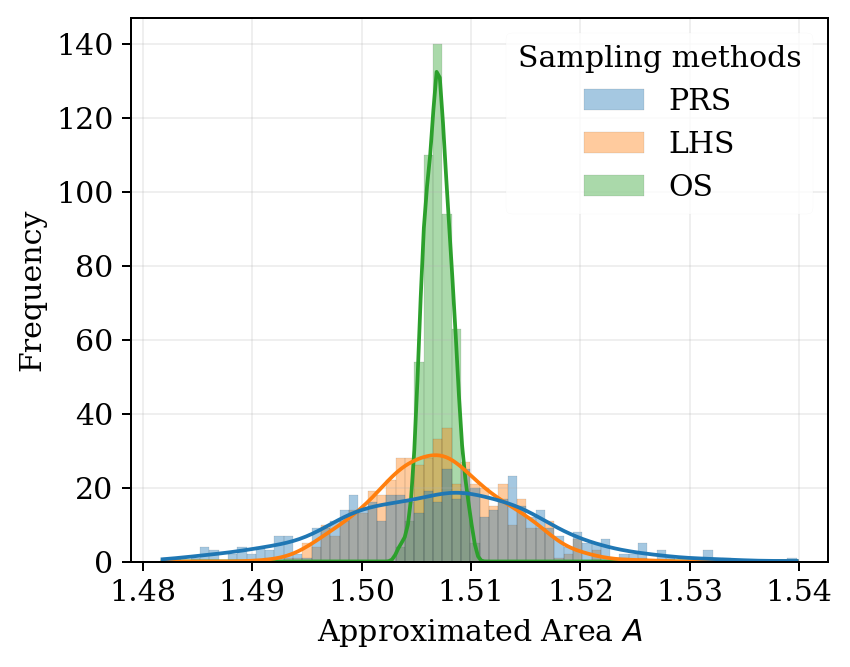

In [10]:
fig = plt.figure(figsize=(5, 4))
plt.grid(alpha = 0.2)
sns.set_context(rc = {'patch.linewidth': 0.03})
sns.histplot(data = df, hue="Sampling methods", x="Approximated Area", alpha=0.4, kde = True)#, kind="kde")
plt.ylabel("Frequency")
plt.xlabel("Approximated Area $A$")
#plt.ylim(-1, 50)
if TEX_PLOTS:
    plt.savefig('figures/dist_sampling_differences.pdf',  bbox_inches='tight')
plt.show()

In [27]:
#Table 
Mean_Uni = np.mean(Approx_areas_list_Uni_Av_est) 
a_Uni = sp_confidence_interval(Approx_areas_list_Uni_Av_est)
Var_Uni = np.var(Approx_areas_list_Uni_Av_est, ddof = 1)

Mean_LHS = np.mean(Approx_areas_list_LHS_Av_est) 
a_LHS = sp_confidence_interval(Approx_areas_list_LHS_Av_est)
Var_LHS = np.var(Approx_areas_list_LHS_Av_est, ddof = 1)

Mean_OS = np.mean(Approx_areas_list_OS_Av_est) 
a_OS = sp_confidence_interval(Approx_areas_list_OS_Av_est)
Var_OS = np.var(Approx_areas_list_OS_Av_est, ddof = 1)


print("PRS: ", "Mean ", round(Mean_Uni, 8),",a", round(a_Uni,8), ",Var ", round(Var_Uni,8))
print(round(Mean_Uni - a_Uni, 8), round(Mean_Uni + a_Uni, 8))
print("lHS: ", "Mean ", round(Mean_LHS, 8),",a", round(a_LHS, 8), ",Var ", round(Var_LHS, 8))
print(round(Mean_LHS - a_LHS, 8), round(Mean_LHS + a_LHS, 8))
print("OS: ", "Mean ", round(Mean_OS, 8),",a", round(a_OS, 8), ",Var ", round(Var_OS,8))
print(round(Mean_OS - a_OS, 8), round(Mean_OS + a_OS, 8))



table = pd.DataFrame(np.array([[Mean_Uni, Mean_LHS, Mean_OS], [a_Uni, a_LHS, a_OS], [Var_Uni, Var_LHS, Var_OS]]), 
                  columns=['PRS', 'LHS', 'OS'], index = ['Mean', 'Radius', 'Variance'])

display(table)

PRS:  Mean  1.5072081 ,a 0.00158732 ,Var  8.159e-05
1.50562078 1.50879542
lHS:  Mean  1.50700583 ,a 0.00101082 ,Var  3.309e-05
1.50599501 1.50801665
OS:  Mean  1.50698137 ,a 0.00021782 ,Var  1.54e-06
1.50676355 1.50719919


,PRS,LHS,OS
Mean,1.507208,1.507006,1.506981
Radius,0.001587,0.001011,0.000218
Variance,0.000082,0.000033,0.000002


### QMS comparison

In [55]:
#%%time
#Chosen samples
#Estimator after convergence (10^5 samples, 10^4 iteration)
#shelf = shelve.open("Final_arrays_simulations/Final_samples")
#Approx_areas_list_I_OS_2_power, iteration_range_I_OS_2_power = I_iter(sample_size = int(2**17), n_runs = 500, I_min_exp = 4, I_max_exp = 4, sampling_method= orthogonal_sampler, steps = 1, seed=672391)
#Approx_areas_list_I_QMS_2_power, iteration_range_I_QMS_2_power = I_iter(sample_size = int(2**17), n_runs = 500, I_min_exp = 4, I_max_exp = 4, sampling_method= scrambled_halton_sampler, steps = 1, seed=672391)
#Approx_areas_list_I_QMS_2_power_sobol, iteration_range_I_QMS_2_power_sobol = I_iter(sample_size = int(2**17), n_runs = 500, I_min_exp = 4, I_max_exp = 4, sampling_method= scrambled_sobol_sampler, steps = 1, seed=672391)

#shelf["Approx_area_S_10^5_2_power_OS"] = Approx_areas_list_I_OS_2_power
#shelf["Approx_area_S_10^5_2_power_QMS"] = Approx_areas_list_I_QMS_2_power
#shelf["Approx_area_S_10^5_2_power_QMS_sobol"] = Approx_areas_list_I_QMS_2_power_sobol
#shelf.close()

In [56]:
#Open objects to work with
shelf = shelve.open("Final_arrays_simulations/Final_samples")
Approx_areas_list_I_OS_2_power = shelf["Approx_area_S_10^5_2_power_OS"] 
Approx_areas_list_I_QMS_2_power = shelf["Approx_area_S_10^5_2_power_QMS_sobol"]
shelf.close()

#Put list in right format (meaning not a list of lists)
Approx_areas_list_OS_Av_est_2_power = sum(Approx_areas_list_I_OS_2_power, [])
Approx_areas_list_QMS_av_est_2_power = sum(Approx_areas_list_I_QMS_2_power, [])

In [59]:
#Table 


Mean_OS = np.mean(Approx_areas_list_OS_Av_est_2_power) 
a_OS = sp_confidence_interval(Approx_areas_list_OS_Av_est_2_power)
Var_OS = np.var(Approx_areas_list_OS_Av_est_2_power, ddof = 1)

Mean_QMS = np.mean(Approx_areas_list_QMS_av_est_2_power) 
a_QMS = sp_confidence_interval(Approx_areas_list_QMS_av_est_2_power)
Var_QMS = np.var(Approx_areas_list_QMS_av_est_2_power, ddof = 1)

print("PRS: ", "Mean ", Mean_OS,",a", a_OS, ",Var ", Var_OS)
print("PRS: ", "Mean ", Mean_QMS,",a", a_QMS, ",Var ", Var_QMS)


table = pd.DataFrame(np.array([[Mean_OS, Mean_QMS], [a_OS, a_QMS], [Var_OS, Var_QMS]]), 
                  columns=[ 'OS', 'QMC'], index = ['Mean', 'Radius', 'Variance'])

display(table)

PRS:  Mean  1.5069632812500002 ,a 0.00019487443305887808 ,Var  1.2297427152584066e-06
PRS:  Mean  1.5069094482421876 ,a 0.0001499143402750036 ,Var  7.27764529909554e-07


,OS,QMC
Mean,1.506963,1.506909e+00
Radius,0.000195,1.499143e-04
Variance,0.000001,7.277645e-07


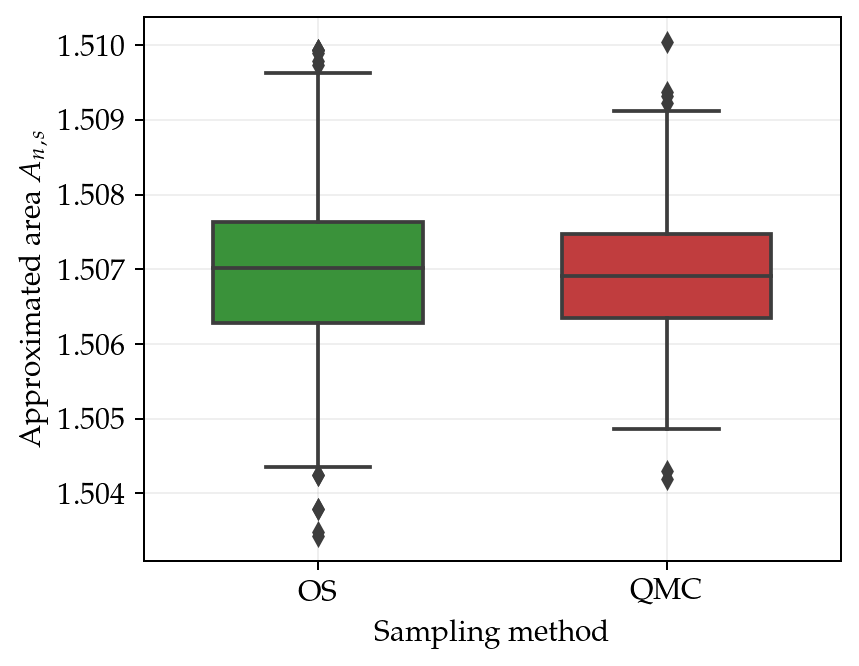

In [60]:
fig = plt.figure(figsize=(5, 4))

Values_OS = np.array(Approx_areas_list_OS_Av_est_2_power)
Values_QMS = np.array(Approx_areas_list_QMS_av_est_2_power)
Data_OS = np.array([np.repeat("OS", len(Values_OS)), Values_OS])
Data_QMS = np.array([np.repeat("QMC", len(Values_QMS)), Values_QMS])
Data = np.concatenate([Data_OS, Data_QMS], axis = 1)

df_qmc = pd.DataFrame(Data.T, columns = ["Sampling methods", "Approximated Area"])
df_qmc = df_qmc.astype({"Approximated Area" : float})
ax = sns.boxplot(x="Sampling methods", y="Approximated Area",  data=df_qmc, width = 0.6, zorder=3,
                 palette={"OS": "tab:green", "QMC": "tab:red"})
plt.grid(alpha = 0.2, zorder=0)
ax.set_axisbelow(True)
plt.ylabel("Approximated area $A_{n,s}$")
plt.xlabel("Sampling method")

if TEX_PLOTS:
    plt.savefig('figures/boxplot_qmc_differences.pdf',  bbox_inches='tight')
    
plt.show()

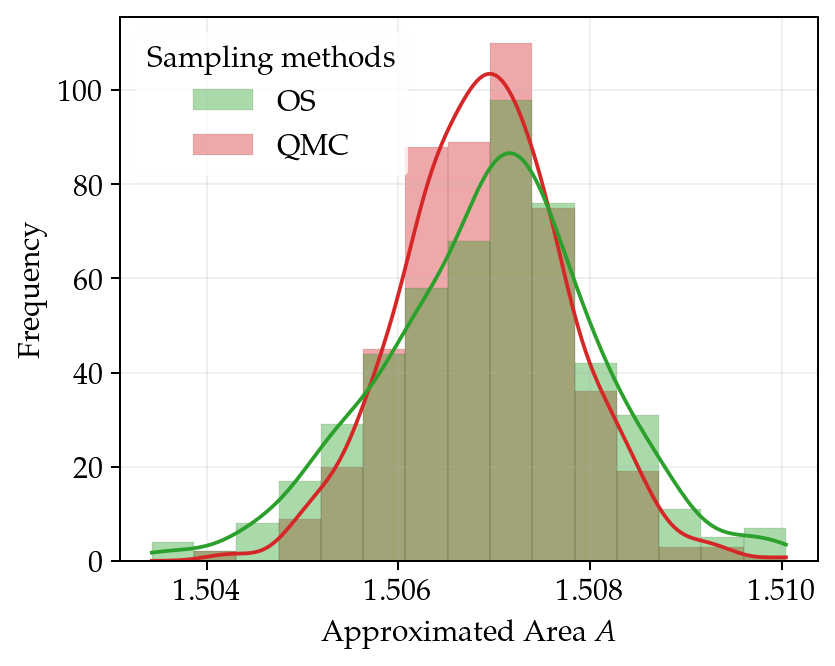

In [61]:
fig = plt.figure(figsize=(5, 4))
plt.grid(alpha = 0.2)
sns.set_context(rc = {'patch.linewidth': 0.03})
sns.histplot(data = df_qmc, hue="Sampling methods", x="Approximated Area", alpha=0.4, kde = True,
             palette={"OS": "tab:green", "QMC": "tab:red"}, bins=15)
plt.ylabel("Frequency")
plt.xlabel("Approximated Area $A$")

if TEX_PLOTS:
    plt.savefig('figures/dist_qmc_differences.pdf',  bbox_inches='tight')
plt.show()

### Statistical test

In [62]:

def F_test(Samples_A, Samples_B, p = 0.95):
    A_var,  A_len = np.var(Samples_A, ddof = 1), len(Samples_A)
    B_var, B_len = np.var(Samples_B, ddof = 1), len(Samples_B)
    F = max(A_var/B_var, B_var/A_var)
    if A_var > B_var:
        n1 = A_len
        n2 = B_len
    else: 
        n2 = A_len
        n1 = B_len
    p_value = 1 - scipy.stats.f.cdf(F, (n1 - 1), (n2 - 1))
    return F, p_value

In [63]:
alpha = 0.05

from statsmodels.stats import multitest 


#Welch tests
statistic_1a, p_value_1a = scipy.stats.ttest_ind(Approx_areas_list_Uni_Av_est, Approx_areas_list_LHS_Av_est, equal_var = False)
statistic_2a, p_value_2a = scipy.stats.ttest_ind(Approx_areas_list_Uni_Av_est, Approx_areas_list_OS_Av_est, equal_var = False)
statistic_3a, p_value_3a = scipy.stats.ttest_ind(Approx_areas_list_LHS_Av_est, Approx_areas_list_OS_Av_est, equal_var = False)
statistic_4a, p_value_4a = scipy.stats.ttest_ind(Approx_areas_list_QMS_av_est_2_power, Approx_areas_list_OS_Av_est_2_power, equal_var = False)


#F tests
statistic_1b, p_value_1b = F_test(Approx_areas_list_Uni_Av_est, Approx_areas_list_LHS_Av_est)
statistic_2b, p_value_2b = F_test(Approx_areas_list_Uni_Av_est, Approx_areas_list_OS_Av_est)
statistic_3b, p_value_3b = F_test(Approx_areas_list_LHS_Av_est, Approx_areas_list_OS_Av_est)
statistic_4b, p_value_4b = F_test(Approx_areas_list_QMS_av_est_2_power, Approx_areas_list_OS_Av_est_2_power)


reject_a, pvals_corrected_a, alphacSidak_a, alphacBonf_a = multitest.multipletests(pvals = [p_value_1a, p_value_2a, p_value_3a, p_value_4a], alpha = alpha, method = "bonferroni")
print(reject_a, pvals_corrected_a, alphacSidak_a, alphacBonf_a)
print("Corrected Alpha: ", alphacBonf_a)

reject_b, pvals_corrected_b, alphacSidak_b, alphacBonf_b = multitest.multipletests(pvals = [p_value_1b, p_value_2b, p_value_3b, p_value_4b], alpha = alpha, method = "bonferroni")
print(reject_b, pvals_corrected_b, alphacSidak_b, alphacBonf_b)
print("Corrected Alpha: ", alphacBonf_b)

print("Statistics Comparison PRS and LHS")
print("Welch-Test: ")
print("Statistic: ", statistic_1a, ", with p-value :", p_value_1a)
print("F-Test: ")
print("Statistic :", statistic_1b, ", with p-value :", p_value_1b, "\n")

print("Statistics Comparison PRS and OS")
print("Welch-Test: ")
print("Statistic: ", statistic_2a, ", with p-value :", p_value_2a)
print("F-Test: ")
print("Statistic :", statistic_2b, ", with p-value :", p_value_2b, "\n")

print("Statistics Comparison OS and LHS")
print("Welch-Test: ")
print("Statistic: ", statistic_3a, ", with p-value :", p_value_3a)
print("F-Test: ")
print("Statistic :", statistic_3b, ", with p-value :", p_value_3b, "\n")

print("Statistics Comparison QRS and OS")
print("Welch-Test: ")
print("Statistic: ", statistic_4a, ", with p-value :", p_value_4a)
print("F-Test: ")
print("Statistic :", statistic_4b, ", with p-value :", p_value_4b, "\n")


[False False False False] [1. 1. 1. 1.] 0.012741455098566168 0.0125
Corrected Alpha:  0.0125
[ True  True  True  True] [4.44089210e-16 4.44089210e-16 4.44089210e-16 1.15488494e-08] 0.012741455098566168 0.0125
Corrected Alpha:  0.0125
Statistics Comparison PRS and LHS
Welch-Test: 
Statistic:  0.42236138880326035 , with p-value : 0.6728685028229762
F-Test: 
Statistic : 2.4659172744457156 , with p-value : 1.1102230246251565e-16 

Statistics Comparison PRS and OS
Welch-Test: 
Statistic:  0.5560728238972809 , with p-value : 0.5784012817594419
F-Test: 
Statistic : 53.10537502854247 , with p-value : 1.1102230246251565e-16 

Statistics Comparison OS and LHS
Welch-Test: 
Statistic:  0.09295487806624549 , with p-value : 0.9259735527029285
F-Test: 
Statistic : 21.53574881804557 , with p-value : 1.1102230246251565e-16 

Statistics Comparison QRS and OS
Welch-Test: 
Statistic:  -0.8603634629547425 , with p-value : 0.38980893889761525
F-Test: 
Statistic : 1.689753573743472 , with p-value : 2.8872123